# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm
model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

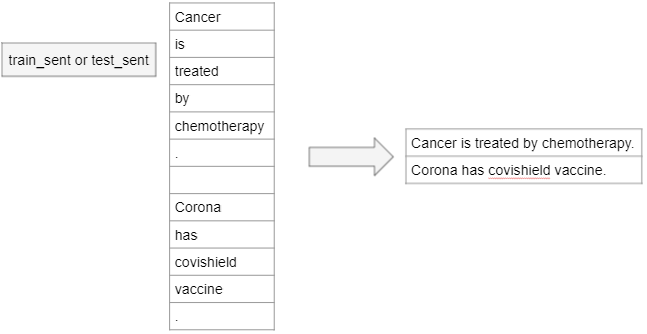

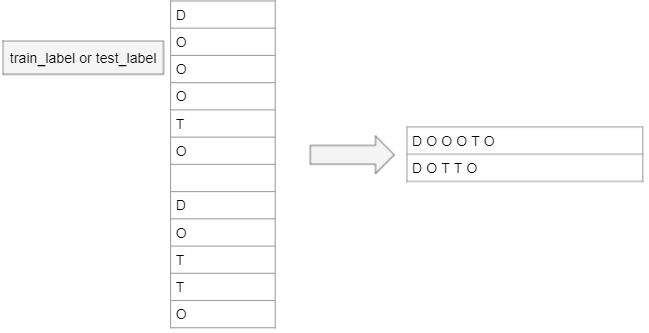

In [2]:
train_doc = open("C:\\Users\\harsh\\Downloads\\pgdai\\nlp assignment CRF\\train_sent", 'r')
test_doc = open("C:\\Users\\harsh\\Downloads\\pgdai\\nlp assignment CRF\\test_sent", 'r')
train_label = open("C:\\Users\\harsh\\Downloads\\pgdai\\nlp assignment CRF\\train_label", 'r')
test_label = open("C:\\Users\\harsh\\Downloads\\pgdai\\nlp assignment CRF\\test_label", 'r')

In [3]:
def preprocess_to_list(input_file):
    file_line = input_file.readlines()
    input_file.close()
    final_sentence_list = []

    sentence = ""

    for sent in file_line:
        sent = sent.strip()
        
        if sent == "":
            final_sentence_list.append(sentence) 
            sentence = "" 
        else:
            if sentence:
                sentence += " " + sent
            else:
                sentence = sent
                
    return final_sentence_list   

### Count the number of sentences in the processed train and test dataset 

In [4]:
train_doc_processed = preprocess_to_list(train_doc)
print("Length of train doc: ", len(train_doc_processed))
print(train_doc_processed[:5])

Length of train doc:  2599
['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]


In [5]:
test_doc_processed = preprocess_to_list(test_doc)
print("Length of test doc: ", len(test_doc_processed))
print(test_doc_processed[:5])

Length of test doc:  1056
['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
train_label_processed = preprocess_to_list(train_label)
print("Length of train label: ", len(train_label_processed))
print(train_label_processed[:5])

Length of train label:  2599
['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [7]:
test_label_processed = preprocess_to_list(test_label)
print("Length of test label: ", len(test_label_processed))
print(test_label_processed[:5])

Length of test label:  1056
['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [8]:
from collections import Counter
count = []
docs = [train_doc_processed, test_doc_processed]
for doc_processed in tqdm(docs):
    for sent in doc_processed:
        doc = model(sent)
        for tok in doc:
            if(tok.pos_ == 'NOUN' or tok.pos_ == 'PROPN'):
                count.append(tok.text)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:43<00:00, 21.59s/it]


In [9]:
c = Counter(count)

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [10]:
for count, word in c.most_common(25):
    print(count, " ", word)

patients   492
treatment   281
%   247
cancer   200
therapy   175
study   152
disease   141
cell   140
lung   116
group   94
chemotherapy   88
gene   87
effects   85
results   78
women   77
use   74
risk   71
cases   71
surgery   71
analysis   70
rate   67
response   66
survival   65
children   64
effect   63


## Defining features for CRF





In [11]:
# Let's define the features to get the feature value for one word.
#Define a function to get the above defined features for a word.
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],
    'word[-2:]=' + word[-2:],
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'words.pos=%s' % model(word)[0].pos_
    ]

    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),
        'perv_words.pos=%s' % model(prev_word)[0].pos_
        ])
    else:
        features.append('BEG') # feature to track begin of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # feature to track end of sentence

    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [12]:
# Define a function to get features for a sentence 
# using the 'getFeaturesForOneWord' function.
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [13]:
# Write a code to get the labels for a sentence.
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [14]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_doc_processed]

X_test = [getFeaturesForOneSentence(sentence) for sentence in test_doc_processed]

### Define the labels as the target variable for test and the train dataset

In [15]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label_processed]

Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label_processed]

## Build the CRF Model

In [16]:
# Build the CRF model.
count_exp = 0
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except:
    count_exp+=1

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [17]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [18]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.907753181285133

In [19]:
for i in range(len(Y_train)):
    for j in range(len(Y_train[i])):
        if Y_train[i][j] == 'D':
            print("Sent ", i+1)
            print("Disease ", train_doc_processed[i].split()[j])
        elif Y_train[i][j] == 'T':
            print("Sent ", i+1)
            print("Treatment ", train_doc_processed[i].split()[j])
            

Sent  13
Disease  gestational
Sent  13
Disease  diabetes
Sent  16
Treatment  glycemic
Sent  16
Treatment  control
Sent  19
Disease  macrosomic
Sent  19
Disease  infants
Sent  19
Disease  in
Sent  19
Disease  gestational
Sent  19
Disease  diabetes
Sent  19
Disease  cases
Sent  19
Treatment  good
Sent  19
Treatment  glycemic
Sent  19
Treatment  control
Sent  21
Disease  Down
Sent  21
Disease  syndrome
Sent  21
Disease  Edward
Sent  21
Disease  syndrome
Sent  21
Disease  trisomies
Sent  21
Disease  Patau
Sent  21
Disease  syndrome
Sent  22
Disease  Down
Sent  22
Disease  syndrome
Sent  22
Disease  Edward
Sent  22
Disease  syndrome
Sent  22
Disease  Patau
Sent  22
Disease  syndrome
Sent  23
Disease  Trisomy
Sent  23
Disease  21
Sent  23
Disease  pyelectasis
Sent  23
Disease  duodenal
Sent  23
Disease  atresia
Sent  24
Disease  trisomy
Sent  24
Disease  13
Sent  24
Disease  bradycardia
Sent  24
Disease  hydronephrosis
Sent  26
Disease  preeclampsia
Sent  28
Disease  preeclampsia
Sent  29
Di

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

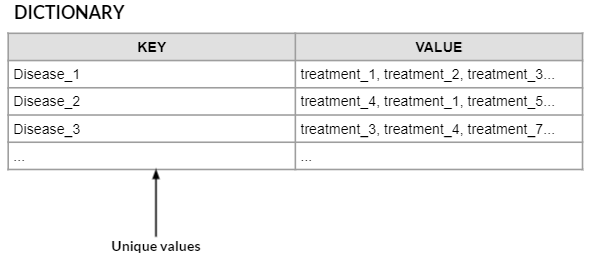

In [20]:
Disease_Treatment_dict=dict()

for lbl in range(len(Y_pred)):
    disease_sentence=""
    treatment_sentence=""
    label=Y_pred[lbl]
    for j in range(len(label)):
        if label[j]=='D':
            disease_sentence=disease_sentence+test_doc_processed[lbl].split()[j]+" "
        if label[j]=='T':
            treatment_sentence=treatment_sentence+test_doc_processed[lbl].split()[j]+" "

    disease_sentence=disease_sentence.lstrip().rstrip()
    treatment_sentence=treatment_sentence.lstrip().rstrip()


    if disease_sentence!='' and treatment_sentence!='':
        if disease_sentence in Disease_Treatment_dict.keys():
            existing_disease_treatment=list(Disease_Treatment_dict[disease_sentence]) 
            existing_disease_treatment.append(treatment_sentence)
            Disease_Treatment_dict[disease_sentence]=existing_disease_treatment
        else:
            Disease_Treatment_dict[disease_sentence]=treatment_sentence

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [21]:
Disease_Treatment_dict['hereditary retinoblastoma']

'radiotherapy'